In [107]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import seaborn as sns

from src.ml_helpers.scorers import *
import jetson_configs as cfg

In [108]:
split_date      = cfg.train_test_split
horizon         = 1 #cfg.horizon
admin_level     = cfg.admin_level
experiment_name = cfg.experiment_name

fpath = f"{admin_level}_lag{horizon}"
#experiment_name = 'tscv_nomeans_noyfill_noyhist'

In [109]:
rename_cols = {
               'Perceptron'        : 'Perceptron',
               'Ridge'             : 'Ridge Regression',
               'Lasso'             : 'Lasso Regression',
               'Randomforest'      :'Random Forest', 
               'lstm_12_100_1layer': "LSTM",
               'Adaboost'          :'AdaBoost', 
               'Xgboost'           :'XGBoost', 
               'Decisiontree'      :'Decision Tree', 
               "em"                : "Expand. Mean",
               #'ewm_12'            : "Exp. Wt. Mean (12)", 
               'ewm_23'            : "Exp. Wt. Mean (23)",
               'ewm_08'            : "Exp. Wt. Mean (8)",  
               'hm_12'             : 'Hist. Mean (12)',  
               'naive_12'          : '12-month lag'}

if horizon==1:
    rename_cols['naive_01']= '1-month lag'

# How do scores degrade with time?

In [110]:
master=pd.read_csv(f"ml/output_data/master_{fpath}.csv", 
                       parse_dates=['date'], 
                       index_col=['date', 'region'])

In [111]:
master.shape

(2160, 96)

In [112]:
master.dropna(axis=0).shape

(827, 96)

In [113]:
# TENTATIVE -- only use comparable predictions
master.dropna(axis=0, inplace=True)

In [114]:
# Confirm equality of the columns
assert(  ((master.ml_true == master.true)          | (master.true.isna()|master.ml_true.isna())) .all())
assert(  ((master.dataset == master.ml_dataset)    | (master.dataset.isna()|master.ml_dataset.isna())  ) .all())

master.drop(columns=['dataset','ml_dataset',
                     #'ml_true', 'eur_true', 
                     #'internal_true', 'external_true', 'h2o_true'
                    ], inplace=True)

In [115]:
models = ['Randomforest', 'Adaboost', 'Ridge', 'Perceptron', #'SVM', 
          'Lasso', 'Decisiontree', 'Xgboost', 'lstm_12_100_1layer']

In [116]:
master.columns = [i.replace("_"+ experiment_name, "") for i in master.columns]

In [117]:
np.sqrt(eval(master['true'], master['hm_12'], 'mse', mean = True))

7174.351122760617

In [118]:
np.sqrt(eval(master.dropna(how='any')['true'], master.dropna(how='any')['hm_12'], 'mse', mean = True))

7174.351122760617

In [119]:
master.sort_index(inplace=True)

# Verify the calculations
np.sqrt(eval(master.dropna(how='any').loc[:split_date]['true'], master.dropna(how='any').loc[:split_date]['hm_12'], 'mse', mean = True))

7428.335688439785

In [120]:
np.sqrt(eval(master.loc[:split_date]['true'], master.loc[:split_date]['hm_12'], 'mse', mean = True))

7428.335688439785

## MAE

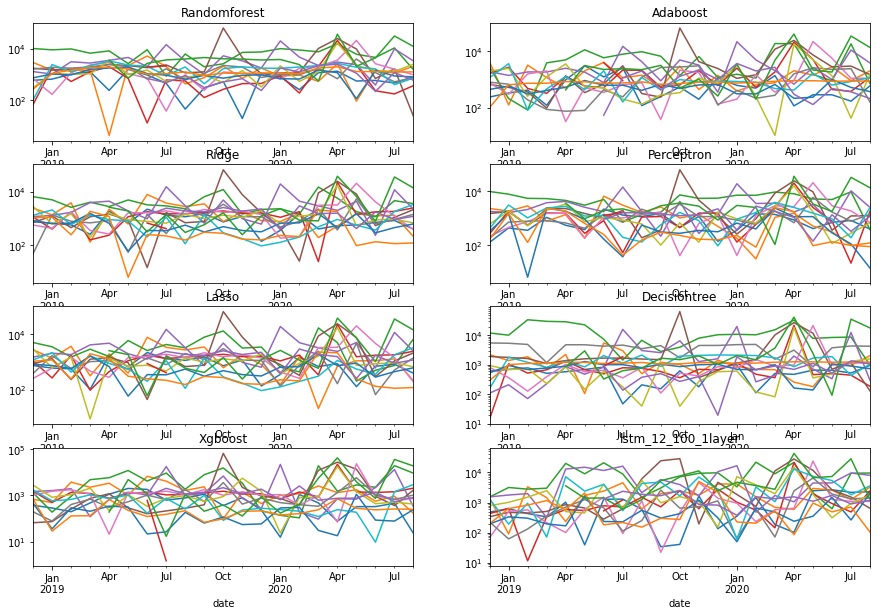

In [121]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mae', mean = False)
    scores.sort_index(inplace=True)
    scores.loc[split_date:].unstack(level='region').plot(legend=False, logy=True, ax = ax[i][j])
    ax[i][j].set_title(models[m])

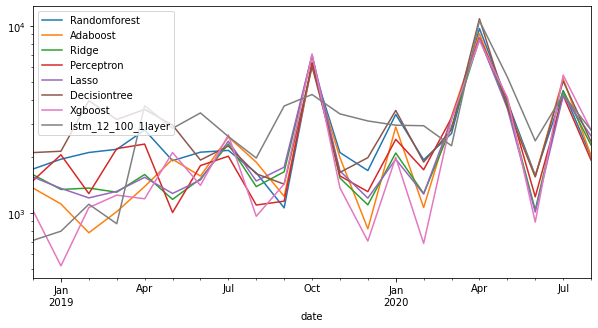

In [122]:
fig, ax = plt.subplots(1,1, figsize=[10,5])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mae', mean = False)
    scores.sort_index(inplace=True)
    
    scores.loc[split_date:].groupby(level='date').mean().plot(label=models[m], 
                                                            logy=True, legend=True, ax = ax)

## MSE

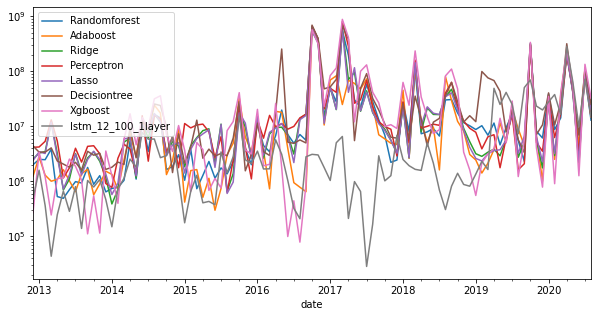

In [123]:
fig, ax = plt.subplots(1,1, figsize=[10,5])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    scores = eval(master['true'], master[models[m]], 'mse', mean = False)
    scores.sort_index(inplace=True)
    
    scores.groupby(level='date').mean().plot(label=models[m], 
                                                            logy=True, legend=True, ax = ax)

# How do scores vary by region?

In [124]:
master_scored = master.copy()

for m in master_scored.columns:
    if m not in ['true', 'ml_true']:
        master_scored[m] = eval(master_scored['true'], master_scored[m], 'mse', mean = False)
        
master_scored.drop(['true', 'ml_true'], axis=1, inplace=True)

master_scored.sort_index(inplace=True)

In [127]:
master_scored.index.get_level_values('region').unique()

Index(['Awdal', 'Banadir', 'Bari', 'Gedo', 'Lower Juba', 'Lower Shabelle',
       'Mudug', 'Sool', 'Togdheer', 'Woqooyi Galbeed', 'Bay', 'Bakool',
       'Middle Juba', 'Middle Shabelle', 'Sanaag'],
      dtype='object', name='region')

In [126]:
master_scored.xs('Nugaal', level='region')

KeyError: 'Nugaal'

In [17]:
#  Get MSE
plot_df_train = master_scored.loc[:split_date].groupby(level='region').mean()
plot_df_test = master_scored.loc[split_date:].groupby(level='region').mean()

In [18]:
# Get RMSE
plot_df_train_rmse = np.sqrt(master_scored.loc[:split_date]).groupby(level='region').mean()
plot_df_test_rmse = np.sqrt(master_scored.loc[split_date:]).groupby(level='region').mean()

In [19]:
# Get normalized RMSE
actual_arrivals = master.sort_index().loc[split_date:]['true'].sort_index(level=[1,0]).groupby('region').mean()

plot_df_train_rmse_normalized = plot_df_train_rmse.div(actual_arrivals, axis=0)
plot_df_test_rmse_normalized = plot_df_test_rmse.div(actual_arrivals, axis=0)

## Raw RMSE

    fig, ax = plt.subplots(2,1, figsize=[20,15], sharex=True)
    sns.heatmap(plot_df_train.rename(columns={"lstm_12_100_1layer":"LSTM"}),cmap='Blues', ax=ax[0], vmin=10000, vmax=100000000)
    sns.heatmap(plot_df_test.rename(columns={"lstm_12_100_1layer":"LSTM"}), cmap='Blues', ax=ax[1], vmin=10000, vmax=100000000)

    ax[0].set_ylabel("")
    ax[1].set_ylabel("")

In [105]:
len(master.index.get_level_values('region').unique())

18

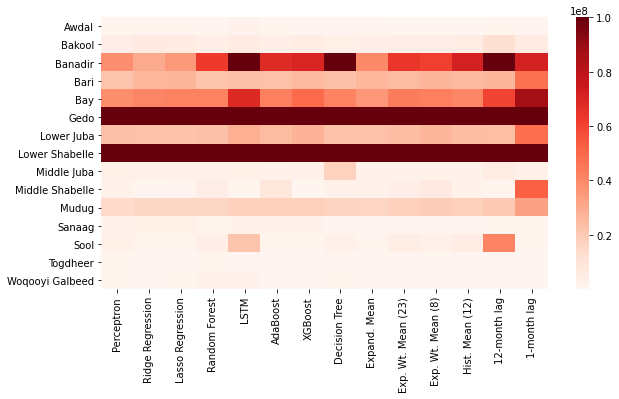

In [20]:
fig, ax = plt.subplots(1,1, figsize=[10,5])
sns.heatmap(plot_df_test[rename_cols.keys()].rename(columns=rename_cols), cmap='Reds', ax=ax, vmin=10000, vmax=100000000)

ax.set_ylabel("")

plt.savefig(f"figures/naive_raw_mse_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")

##### Ranked RMSE

    fig, ax = plt.subplots(2,1, figsize=[20,15], sharex=True)
    sns.heatmap(plot_df_train.rename(columns={"lstm_12_100_1layer":"LSTM"}).rank(axis=1), cmap='Greens', ax=ax[0])
    sns.heatmap(plot_df_test.rename(columns={"lstm_12_100_1layer":"LSTM"}).rank(axis=1), cmap='Greens', ax=ax[1])

    ax[0].set_ylabel("")
    ax[1].set_ylabel("")

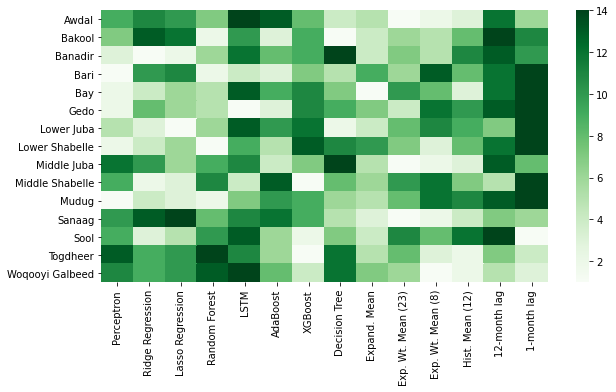

In [21]:
fig, ax = plt.subplots(1,1, figsize=[10,5])
sns.heatmap(plot_df_test[rename_cols.keys()].rename(columns=rename_cols).rank(axis=1), cmap='Greens', ax=ax)

ax.set_ylabel("")

plt.savefig(f"figures/naive_ranked_mse_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")

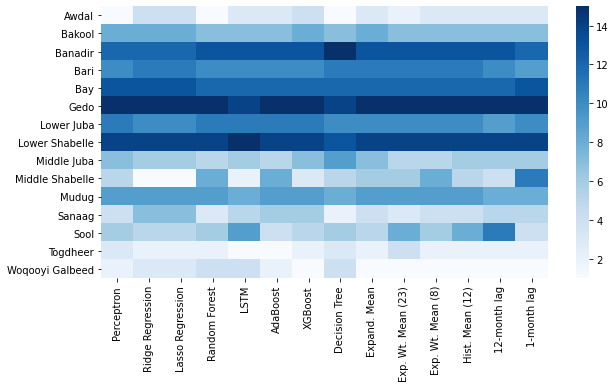

In [22]:
fig, ax = plt.subplots(1,1, figsize=[10,5])
sns.heatmap(plot_df_test[rename_cols.keys()].rename(columns=rename_cols).rank(axis=0), cmap='Blues', ax=ax)

ax.set_ylabel("")

plt.savefig(f"figures/naive_ranked_mse_{admin_level}_{horizon}_by_region.png", dpi=100, bbox_inches="tight")

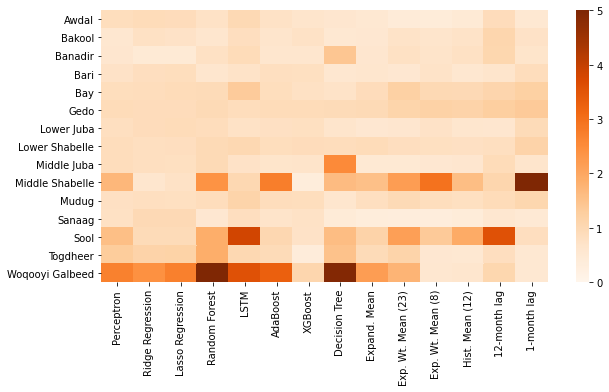

In [23]:
fig, ax = plt.subplots(1,1, figsize=[10,5])
sns.heatmap(plot_df_test_rmse_normalized[rename_cols.keys()].rename(columns=rename_cols), cmap='Oranges', ax=ax, vmin=0, vmax=5)

ax.set_ylabel("")

plt.savefig(f"figures/naive_normalized_rmse_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")

## Raw RMSE -- train vs. test

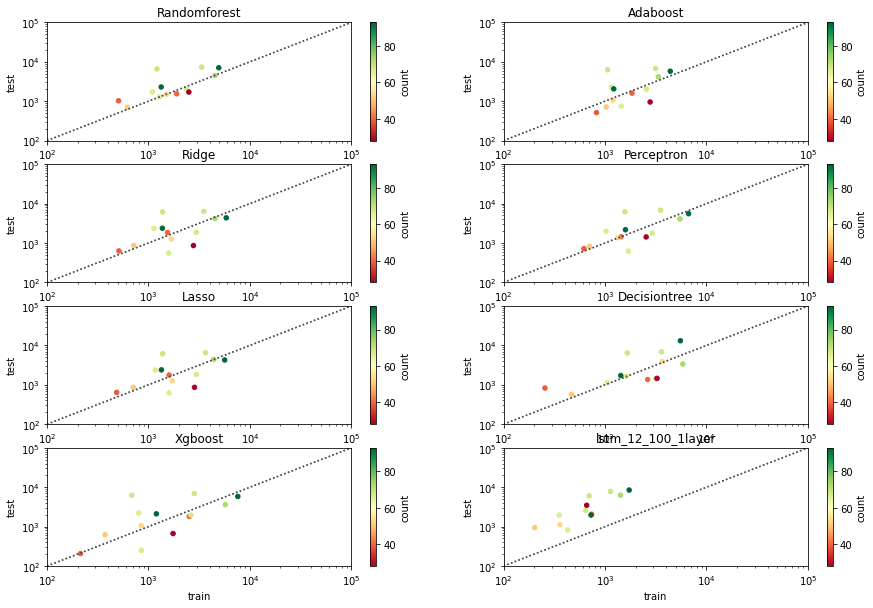

In [24]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    
    plot_df = pd.concat([master.groupby(level='region').mean()[['true']], 
                         master.groupby(level='region').count()[['true']],
                         plot_df_train_rmse[models[m]],
                         plot_df_test_rmse[models[m]]],
                         axis=1)

    plot_df.columns=['true', 'count', 'train', 'test']

    plot_df.plot(x='train', y='test', kind='scatter', logx=True, logy=True, c='count', cmap='RdYlGn', ax=ax[i][j])

    lim=[100,100000]
    ax[i][j].set_xlim(lim)
    ax[i][j].set_ylim(lim)

    ax[i][j].plot(lim,lim, ls=":", c=".3")
    ax[i][j].plot(lim,lim, ls=":", c=".3")
    
    ax[i][j].set_title(models[m])

## Ranked RMSE -- train vs. test

In [25]:
plot_df_train_rmse_rank = plot_df_train_rmse.rank(axis=1)
plot_df_test_rmse_rank = plot_df_test_rmse.rank(axis=1)

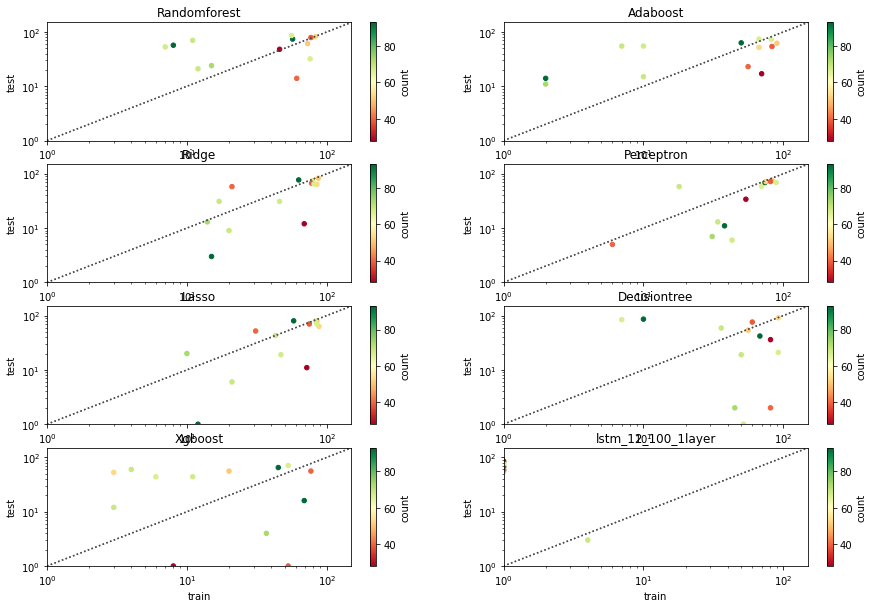

In [26]:
fig, ax = plt.subplots(4,2, figsize=[15,10])

for m in range(0,len(models)):
    i = m//2
    j = m%2
    
    
    plot_df = pd.concat([master.groupby(level='region').mean()[['true']], 
                         master.groupby(level='region').count()[['true']],
                         plot_df_train_rmse_rank[models[m]],
                         plot_df_test_rmse_rank[models[m]]],
                         axis=1)

    plot_df.columns=['true', 'count', 'train', 'test']

    plot_df.plot(x='train', y='test', kind='scatter', logx=True, logy=True, c='count', cmap='RdYlGn', ax=ax[i][j])

    lim=[1,150]
    ax[i][j].set_xlim(lim)
    ax[i][j].set_ylim(lim)

    ax[i][j].plot(lim,lim, ls=":", c=".3")
    ax[i][j].plot(lim,lim, ls=":", c=".3")
    
    ax[i][j].set_title(models[m])

# Evaluate generally

In [27]:
results = pd.concat([make_results("admin1_lag1", split_date),
                     make_results("admin1_lag3", split_date)], axis=1)

results = results.astype(float)
results.to_csv("ml/results/scored_models.csv")

## RMSE

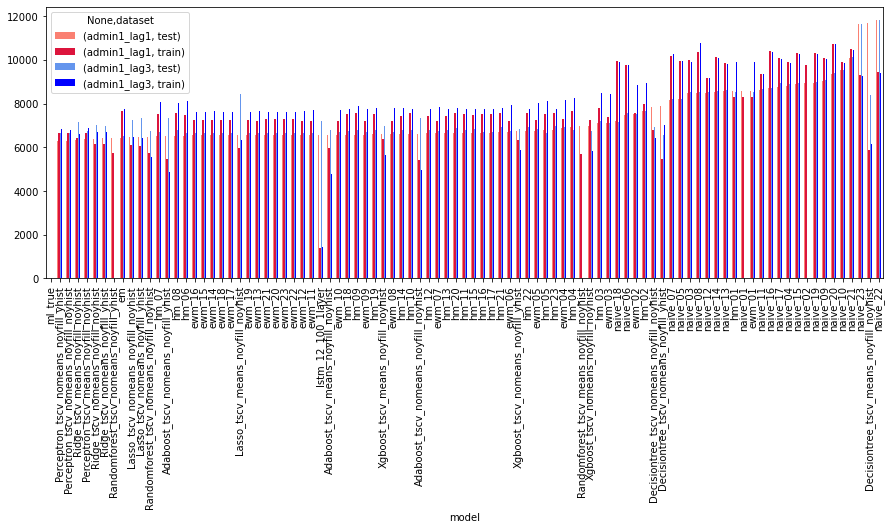

In [28]:
plot_df =  results.xs('rmse', level='metric').round(0).unstack(level='dataset').sort_values(('admin1_lag1', 'test'))
plot_df.plot(kind='bar',
             color=['salmon', 'crimson', 'cornflowerblue', 'blue'], figsize=[15,5]) #.xs("test", level="dataset").plot(kind='bar') #kind='bar') #.sort_values('admin1_lag3') #.xs("test", level="dataset").plot(kind='bar')

# Build Results table

## Get top performing baseline models

In [29]:
plot_df = results.xs('rmse', level='metric').round(0).unstack(level='dataset') #.sort_index()

In [30]:
plot_df = plot_df.T.sort_index(level=[0,'dataset'], ascending=False).loc[['admin1_lag1', 'admin1_lag3']].T

In [31]:
plot_df['model_class'] = plot_df.index.get_level_values(0)
plot_df['model_class'] = plot_df['model_class'].apply(lambda x: x.split("_")[0])

In [32]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'ewm' in i][:3]

['ewm_08', 'ewm_09', 'ewm_07']

In [33]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'ewm' in i][:3]

['ewm_23', 'ewm_22', 'ewm_21']

In [34]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'hm' in i][:3]

['hm_12', 'hm_13', 'hm_14']

In [35]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'hm' in i][:3]

['hm_12', 'hm_17', 'hm_11']

In [36]:
[i for i in plot_df.sort_values(('admin1_lag1', 'train')).index.get_level_values(0).tolist() if 'naive' in i][:3]

['naive_01', 'naive_12', 'naive_23']

In [37]:
[i for i in plot_df.sort_values(('admin1_lag3', 'train')).index.get_level_values(0).tolist() if 'naive' in i][:3]

['naive_12', 'naive_23', 'naive_11']

In [38]:
cols = ['Decisiontree', 'Randomforest', 'Lasso', 'Ridge', # 'SVM', 
        'Adaboost', 'Xgboost', 'Perceptron', 'lstm_12_100_1layer',
            'em', #'ewm_12',
        'hm_12', 'ewm_08', 'ewm_23', #'ewm_18', 'ewm_15', 'hm_13', 'hm_09', 
        'naive_12', 'naive_01']

## Table of top models 

In [39]:
plot_df = plot_df.T
plot_df.columns = [i.replace("_"+experiment_name,"") for i in plot_df.columns]
plot_df = plot_df.rename(columns=rename_cols).T

cols = [rename_cols[i] if i in rename_cols.keys()  else i for i in cols   ]

In [40]:
plot_df = plot_df.loc[cols].sort_values((f'admin1_lag1', 'test'))

plot_df = plot_df.fillna("-")

plot_df

admin1_lag1         admin1_lag3         model_class
dataset                  train    test       train  test              
Perceptron              6660.0  6288.0        6811  6669    Perceptron
Ridge Regression        6152.0  6389.0        6709  7015         Ridge
Expand. Mean            7683.0  6437.0        7767  6512            em
Lasso Regression        6084.0  6449.0        6457  7267         Lasso
Random Forest           5760.0  6471.0        5564  6754  Randomforest
Exp. Wt. Mean (23)      7303.0  6546.0        7600  6674           ewm
LSTM                    1377.0  6555.0        1449  7195          lstm
Exp. Wt. Mean (8)       7195.0  6601.0        7794  6702           ewm
AdaBoost                5424.0  6631.0        4962  7361      Adaboost
Hist. Mean (12)         7428.0  6632.0        7739  6774            hm
XGBoost                 7239.0  6965.0        5849  6749       Xgboost
Decision Tree           6791.0  7853.0        6421  6936  Decisiontree
12-month lag            9167.0  8487.0        9150  8537         naive
1-month lag             8294.0  8594.0           -     -         naive

In [41]:
plot_df = plot_df[['admin1_lag1', 'admin1_lag3']].T.reset_index(level='dataset').T

In [42]:
plot_df.to_latex("tables/results.tex", 
    header=['1-month horizon', '', '3-month horizon', ''])

In [43]:
for i, row in plot_df.iterrows():
    print (i, "&", " & ".join([str(i).replace(".0", "") for i in row.values.tolist()[:-1] if ~pd.isna(i)] ), "\\\\")

dataset & train & test & train \\
Perceptron & 6660 & 6288 & 6811 \\
Ridge Regression & 6152 & 6389 & 6709 \\
Expand. Mean & 7683 & 6437 & 7767 \\
Lasso Regression & 6084 & 6449 & 6457 \\
Random Forest & 5760 & 6471 & 5564 \\
Exp. Wt. Mean (23) & 7303 & 6546 & 7600 \\
LSTM & 1377 & 6555 & 1449 \\
Exp. Wt. Mean (8) & 7195 & 6601 & 7794 \\
AdaBoost & 5424 & 6631 & 4962 \\
Hist. Mean (12) & 7428 & 6632 & 7739 \\
XGBoost & 7239 & 6965 & 5849 \\
Decision Tree & 6791 & 7853 & 6421 \\
12-month lag & 9167 & 8487 & 9150 \\
1-month lag & 8294 & 8594 & - \\


In [44]:
master.true.mean()

3255.024183796856

In [45]:
master.true.std()

7699.58931528895

In [46]:
master.true.max()

76267.0

In [47]:
master.true.median()

1084.0

In [48]:
master.groupby(level='region').mean().true.sort_values()

region
Togdheer            411.128205
Awdal               694.980392
Woqooyi Galbeed     824.432836
Middle Shabelle     860.500000
Sool               1266.714286
Middle Juba        1336.320755
Bari               1607.880597
Sanaag             1679.866667
Lower Juba         1768.817204
Gedo               2696.521739
Bakool             2847.275000
Mudug              2914.676471
Lower Shabelle     4409.913043
Bay                6433.821918
Banadir            9759.655914
Name: true, dtype: float64

## Plot ranked errors

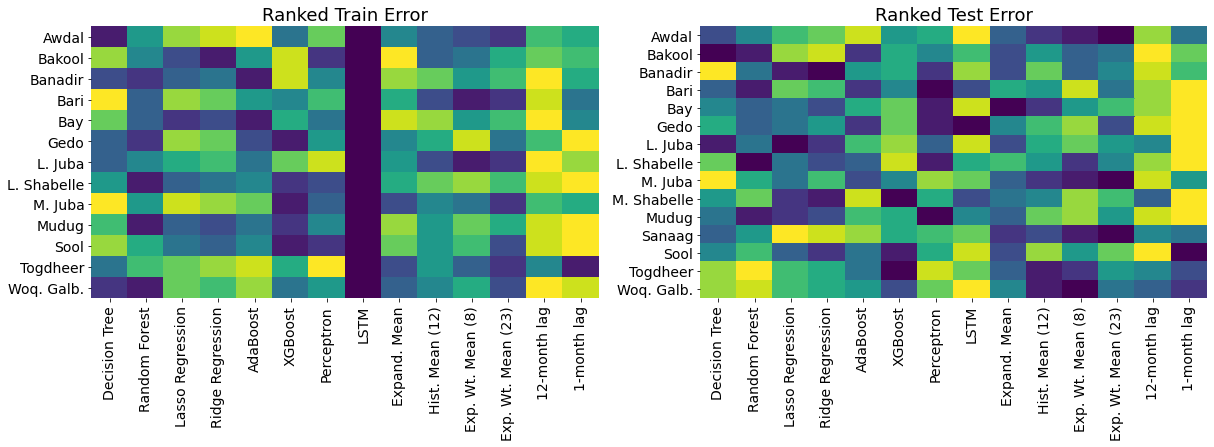

In [49]:
plot_df_train.rename(columns=rename_cols, inplace=True)
plot_df_test.rename(columns=rename_cols, inplace=True)

fig, ax = plt.subplots(1,2, figsize=[20,5])
sns.heatmap(plot_df_train[cols].rank(axis=1), cmap='viridis', ax=ax[0], cbar=None)
sns.heatmap(plot_df_test[cols].rank(axis=1), cmap='viridis', ax=ax[1], cbar=None)

ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_title("Ranked Train Error", fontsize=18)
ax[1].set_title("Ranked Test Error", fontsize=18)

ax[0].set_yticklabels([i.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in plot_df_train.index], fontsize=14)


ax[1].set_yticklabels([i.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in plot_df_test.index], fontsize=14)

for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

plt.savefig(f"figures/ranked_error_{admin_level}_{horizon}.png", dpi=100, bbox_inches="tight")

# Compare the results of different experiments

In [50]:
all_res = results.xs('rmse', level='metric').round(0).unstack(level='dataset')

In [51]:
means_noyfill_noyhist = [i for i in all_res.index.get_level_values(0).unique() if '_means_noyfill_noyhist' in i]
nomeans_noyfill_noyhist = [i for i in all_res.index.get_level_values(0).unique() if '_nomeans_noyfill_noyhist' in i]
nomeans_noyfill_yhist = [i for i in all_res.index.get_level_values(0).unique() if '_nomeans_noyfill_yhist' in i]

(8000.0, 10500.0)

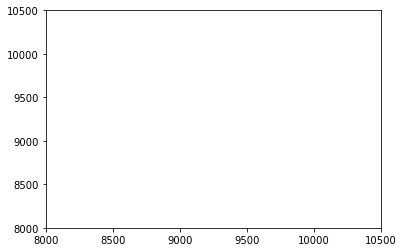

In [52]:
fig, ax= plt.subplots(1,1)

ax.scatter(x=all_res.loc[nomeans_noyfill_noyhist][('admin1_lag1', 'test')], y=all_res.loc[nomeans_noyfill_yhist][('admin1_lag1', 'test')], alpha=0.5, label='yhist') #.mean()
ax.scatter(x=all_res.loc[nomeans_noyfill_noyhist][('admin1_lag1', 'test')], y=all_res.loc[means_noyfill_noyhist][('admin1_lag1', 'test')], alpha=0.5, label='means') #.mean()
#ax.scatter(x=all_res.loc[nomeans_noyfill_yhist][('admin1_lag1', 'test')], y=all_res.loc[means_noyfill_noyhist][('admin1_lag1', 'test')], alpha=0.5) #.mean()

ax.set_xlim(8000, 10500)
ax.set_ylim(8000, 10500)

(5000.0, 8000.0)

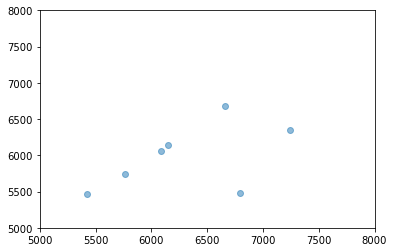

In [53]:
fig, ax= plt.subplots(1,1)

ax.scatter(x=all_res.loc[nomeans_noyfill_noyhist][('admin1_lag1', 'train')], y=all_res.loc[nomeans_noyfill_yhist][('admin1_lag1', 'train')], alpha=0.5, label='yhist') #.mean()
#ax.scatter(x=all_res.loc[nomeans_noyfill_noyhist][('admin1_lag1', 'train')], y=all_res.loc[means_noyfill_noyhist][('admin1_lag1', 'train')], alpha=0.5, label='means') #.mean()
#ax.scatter(x=all_res.loc[nomeans_noyfill_yhist][('admin1_lag1', 'train')], y=all_res.loc[means_noyfill_noyhist][('admin1_lag1', 'train')], alpha=0.5) #.mean()

ax.set_xlim(5000, 8000)
ax.set_ylim(5000, 8000)

In [54]:
all_res.loc[nomeans_noyfill_yhist].mean()

             dataset
admin1_lag1  test       6676.142857
             train      5989.714286
admin1_lag3  test       6960.166667
             train      6288.000000
dtype: float64

In [55]:
all_res.loc[nomeans_noyfill_noyhist].mean()

             dataset
admin1_lag1  test       6720.857143
             train      6301.428571
admin1_lag3  test       6964.428571
             train      6110.428571
dtype: float64

In [56]:
all_res.loc[means_noyfill_noyhist].mean()

             dataset
admin1_lag1  test       7293.714286
             train      6140.142857
admin1_lag3  test       7413.666667
             train      6078.000000
dtype: float64